## Домашнее задание

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
# from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, log_loss, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('./../../3Урок/materials_lection3/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

### Задание 1	
обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

### Задание 2
при обучении моделей обязательно использовать кроссвалидацию

#### LogisticRegression

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc') # roc_auc
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


In [8]:
roc_auc = roc_auc_score(y_test, y_score)

In [9]:
results=[]

In [10]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

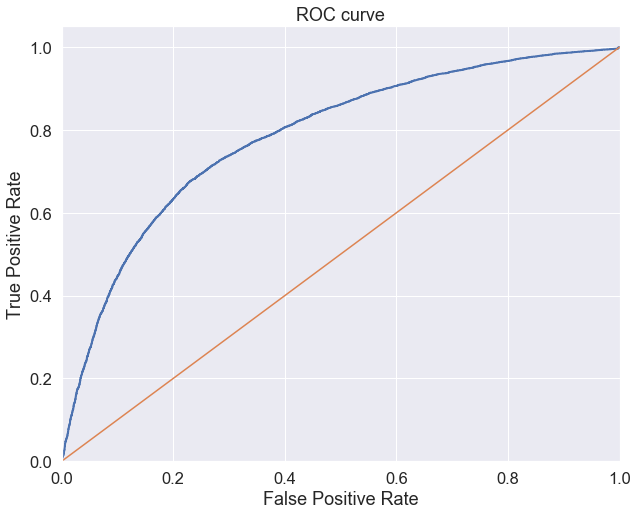

In [11]:
def plot_roc_curve (y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
#     plt.savefig("ROC.png")
    plt.show()
    
plot_roc_curve(y_test, y_score)

Посомтрим на матрицу ошибок

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Посчитаем FPR, TPR

In [14]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

#### RandomForest

In [15]:
from sklearn.ensemble import RandomForestClassifier 

In [16]:
%%time
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=100, max_features=11, max_depth=8)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc') # roc_auc
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.8007885854652583+-0.005826337987611165
Wall time: 49.1 s


In [17]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score_proba = classifier.predict_proba(X_test)
# y_score = classifier.predict(X_test)

In [18]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_proba[:,1])
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, y_score_proba[:,1])
print(f'Roc_auc={roc_auc:.4f}')

Best Threshold=0.334011, F-Score=0.739, Precision=0.656, Recall=0.845
Roc_auc=0.8007


In [19]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

In [20]:
cnf_matrix = confusion_matrix(y_test, y_score_proba[:,1]>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8445852534562212, 0.4350340136054422, 0.5649659863945579)

#### KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
%%time
classifier = Pipeline([
    ('features',feats),
    ('classifier', KNeighborsClassifier(n_neighbors=8)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc') # roc_auc
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7079981230811001+-0.004987306713110735
Wall time: 23.7 s


In [24]:
classifier.fit(X_train, y_train)
y_score_proba = classifier.predict_proba(X_test)
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_proba[:,1])
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, y_score_proba[:,1])
print(f'Roc_auc={roc_auc:.4f}')

Best Threshold=0.375000, F-Score=0.695, Precision=0.593, Recall=0.840
Roc_auc=0.7087


In [25]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

In [26]:
cnf_matrix = confusion_matrix(y_test, y_score_proba[:,1]>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7005760368663595, 0.3885487528344671, 0.6114512471655329)

#### AdaBoost

In [29]:
from sklearn.ensemble import AdaBoostClassifier 

In [30]:
%%time
classifier = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc') # roc_auc
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7948224583227615+-0.005095925066493213
Wall time: 13.7 s


In [31]:
classifier.fit(X_train, y_train)
y_score_proba = classifier.predict_proba(X_test)
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_proba[:,1])
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
roc_auc = roc_auc_score(y_test, y_score_proba[:,1])
print(f'Roc_auc={roc_auc:.4f}')

Best Threshold=0.497430, F-Score=0.738, Precision=0.692, Recall=0.789
Roc_auc=0.7946


In [32]:
results.append([precision[ix], recall[ix],fscore[ix],roc_auc])

In [33]:
cnf_matrix = confusion_matrix(y_test, y_score_proba[:,1]>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7892857142857143, 0.3450113378684807, 0.6549886621315193)

In [35]:
res = pd.DataFrame(results, columns=['Precision','Recall','Fscore','Roc_auc'])
res['Approach']=['LogisticRegression','RandomForest','KNN','AdaBoost']
res

,Precision,Recall,Fscore,Roc_auc,Approach
0,0.647431,0.837558,0.730323,0.784035,LogisticRegression
1,0.656460,0.844700,0.738778,0.800687,RandomForest
2,0.592602,0.839747,0.694852,0.708695,KNN
3,0.692471,0.789401,0.737766,0.794572,AdaBoost


### Задание 4	
Выводы

Самые высокие значения метрик roc_auc и f_score являются у подходов RandomForest и AdaBoost. Для выбора лучшей модели необходимо дополнительно оценить значения precision и recall, при чем необходимо учитывать бизнес цели. В рамках данной задачи, по моему мнению, самым важным параметром считается recall. Нам важно выявить как можно больше потенциальных больных и отправить их на обследование, даже если мы отправим много здоровых (precision). Лучший подход - RandomForest. 

### Задание 5
какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:
•	первая помечает 100 объектов как класс 1, но TP = 90
•	вторая помечает 1000 объектов как класс 1, но TP такой же - 90

подход 1

In [42]:
TN = 99890
FN = 10
TP = 90
FP = 10

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print(f'TPR={TPR}, FPR={FPR}')

pr = TP/(TP+FP)
rec = TPR
print(f'precision={pr}, recall={rec}') 

TPR=0.9, FPR=0.0001001001001001001
precision=0.9, recall=0.9


подход 2

In [43]:
TN = 99900-910
FN = 10
TP = 90
FP = 910

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print(f'TPR={TPR}, FPR={FPR}')

pr = TP/(TP+FP)
rec = TPR
print(f'precision={pr}, recall={rec}') 

TPR=0.9, FPR=0.00910910910910911
precision=0.09, recall=0.9


precision_recall_curve нам в помощь